# Counter Strike : Round Winner Predictor

CS:GO is a tactical shooter, where two teams (CT and Terrorist) play for a best of 30 rounds, with each round being 1 minute and 55 seconds. There are 5 players on each team (10 in total) and the first team to reach 16 rounds wins the game. At the start, one team plays as CT and the other as Terrorist. After 15 rounds played, the teams swap side. There are 7 different maps a game can be played on. You win a round as Terrorist by either planting the bomb and making sure it explodes, or by eliminating the other team. You win a round as CT by either eliminating the other team, or by disarming the bomb, should it have been planted.

The dataset was originally published by Skybox as part of their CS:GO AI Challenge, running from Spring to Fall 2020. The data set consists of ~700 demos from high level tournament play in 2019 and 2020. Warmup rounds and restarts have been filtered, and for the remaining live rounds a round snapshot have been recorded every 20 seconds until the round is decided. Following the initial publication, It has been pre-processed and flattened to improve readability and make it easier for algorithms to process. The total number of snapshots is 122411.

Skybox website: https://skybox.gg/
Learn more about CS:GO: https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive
View CS:GO on Steam Store: https://store.steampowered.com/app/730/CounterStrike_Global_Offensive/
Find in-depth information on competitive CS:GO: https://www.hltv.org/

## Data Dictionary
Note: All snapshots are i.i.d in the sense that they each describe the state of a round
and can therefore be treated individually. Although multiple snaphots can be taken from the same round.

You are suppose to predict a label (round winner) based on each individual snapshot.

time_left-  The time left in the current round.	
ct_score-   The current score of the Counter-Terrorist team.	
t_score-	The current score of the Terrorist team.	
map-	    The map the round is being played on.	E.g. de_dust2, de_inferno and de_overpass
bomb_planted-	If the bomb has been planted or not.	False = No, True = Yes
ct_health-	The total health of all Counter-Terrorist players.	Player health in range 0-100.
t_health-	The total health of all Terrorist players.	Player health in range 0-100.
ct_armor-	The total armor of all Counter-Terrorist players.	
t_armor-	The total armor of all Terrorist players.	
ct_money-	The total bankroll of all Counter-Terrorist players.	Amount in USD.
t_money-	The total bankroll of all Terrorist players.	Amount in USD.
ct_helmets-	Number of helmets on the Counter-Terrorist team.	
t_helmets-	Number of helmets on the Terrorist team.	
ct_defuse_kits-	    Number of defuse kits on the Counter-Terrorist team.	
ct_players_alive-	Number of alive players on the Counter-Terrorist team.	Range 0 to 5.
t_players_alive-	Number of alive players on the Terrorist team.	Range 0 to 5.
ct_weapon_X	Weapon- X count on Counter-Terrorist team.	E.g. Ak47, Deagle and UMP45.
t_weapon_X	Weapon- X count on Terrorist team.	E.g. Ak47, Deagle and UMP45.
ct_grenade_X-	Grenade X count on Counter-Terrorist team.	E.g. HeGrenade, Flashbang.
t_grenade_X-	Grenade X count on Terrorist team.	E.g. HeGrenade, Flashbang.
round_winner-	Winner.	CT = Counter-Terrorist, T = Terrorist

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

## Get the Data

In [2]:
cs = pd.read_csv('csgo_round_snapshots.csv')

In [3]:
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

In [4]:
cs['map'].nunique()

8

In [5]:
cs.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,...,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,...,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,166.917500,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
max,175.000000,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,...,7.000000,7.000000,6.000000,9.000000,5.000000,3.000000,3.000000,5.000000,3.000000,2.000000


In [6]:
cs

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,de_train,True,200.0,242.0,195.0,359.0,100.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122406,174.93,11.0,15.0,de_train,False,500.0,500.0,95.0,175.0,11500.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122407,114.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0,T
122408,94.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,5.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,T


# Exploratory Data Analysis

<AxesSubplot:xlabel='map', ylabel='count'>

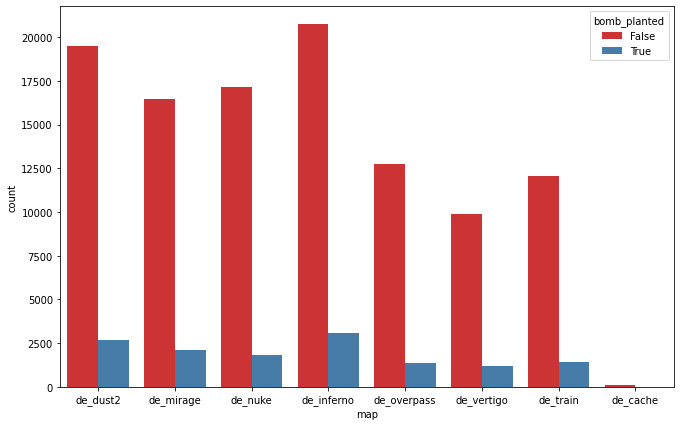

In [7]:
plt.figure(figsize=(11,7))
sns.countplot(x='map',hue='bomb_planted',data=cs,palette='Set1')

<AxesSubplot:xlabel='map', ylabel='count'>

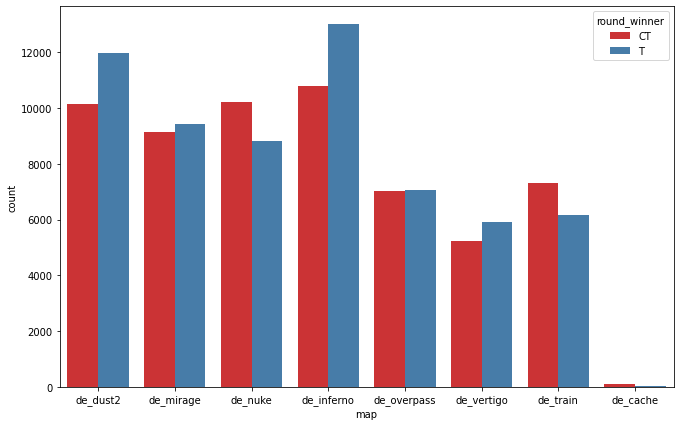

In [8]:
plt.figure(figsize=(11,7))
sns.countplot(x='map',hue='round_winner',data=cs,palette='Set1')

# Setting up the Data

In [9]:
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

## Categorical Features

In [10]:
cat_feats = ['map']

In [11]:
final_data = pd.get_dummies(cs,columns=cat_feats)

In [12]:
for i in range(0,final_data.shape[0]):
    if final_data.loc[i,'bomb_planted']==False:
        final_data.loc[i,'bomb_planted']=0
    else:
        final_data.loc[i,'bomb_planted']=1

In [13]:
final_data

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,t_grenade_decoygrenade,round_winner,map_de_cache,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo
0,175.00,0.0,0.0,0,500.0,500.0,0.0,0.0,4000.0,4000.0,...,0.0,CT,0,1,0,0,0,0,0,0
1,156.03,0.0,0.0,0,500.0,500.0,400.0,300.0,600.0,650.0,...,0.0,CT,0,1,0,0,0,0,0,0
2,96.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,CT,0,1,0,0,0,0,0,0
3,76.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,CT,0,1,0,0,0,0,0,0
4,174.97,1.0,0.0,0,500.0,500.0,192.0,0.0,18350.0,10750.0,...,0.0,CT,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,1,200.0,242.0,195.0,359.0,100.0,5950.0,...,0.0,T,0,0,0,0,0,0,1,0
122406,174.93,11.0,15.0,0,500.0,500.0,95.0,175.0,11500.0,23900.0,...,0.0,T,0,0,0,0,0,0,1,0
122407,114.93,11.0,15.0,0,500.0,500.0,495.0,475.0,1200.0,6700.0,...,0.0,T,0,0,0,0,0,0,1,0
122408,94.93,11.0,15.0,0,500.0,500.0,495.0,475.0,1200.0,6700.0,...,0.0,T,0,0,0,0,0,0,1,0


## Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X = final_data.drop('round_winner',axis = 1)
y = final_data['round_winner']
y = y.map({'CT': 1, 'T': 0}).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [16]:
X

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,ct_grenade_decoygrenade,t_grenade_decoygrenade,map_de_cache,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo
0,175.00,0.0,0.0,0,500.0,500.0,0.0,0.0,4000.0,4000.0,...,0.0,0.0,0,1,0,0,0,0,0,0
1,156.03,0.0,0.0,0,500.0,500.0,400.0,300.0,600.0,650.0,...,0.0,0.0,0,1,0,0,0,0,0,0
2,96.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,0.0,0,1,0,0,0,0,0,0
3,76.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,0.0,0,1,0,0,0,0,0,0
4,174.97,1.0,0.0,0,500.0,500.0,192.0,0.0,18350.0,10750.0,...,0.0,0.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,1,200.0,242.0,195.0,359.0,100.0,5950.0,...,0.0,0.0,0,0,0,0,0,0,1,0
122406,174.93,11.0,15.0,0,500.0,500.0,95.0,175.0,11500.0,23900.0,...,0.0,0.0,0,0,0,0,0,0,1,0
122407,114.93,11.0,15.0,0,500.0,500.0,495.0,475.0,1200.0,6700.0,...,0.0,0.0,0,0,0,0,0,0,1,0
122408,94.93,11.0,15.0,0,500.0,500.0,495.0,475.0,1200.0,6700.0,...,0.0,0.0,0,0,0,0,0,0,1,0


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
classifier_lr = LogisticRegression(max_iter = 300, random_state = 0)
classifier_lr.fit(X_train, y_train)

C:\Users\akshat.batra.91\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, random_state=0)

In [19]:
print("Test Set:")
print("Accuracy = {:.2f}".format(accuracy_score(y_test, classifier_lr.predict(X_test))), "Confusion Matrix: ", confusion_matrix(y_test, classifier_lr.predict(X_test)), sep = "\n")

Test Set:
Accuracy = 0.74
Confusion Matrix: 
[[13758  4840]
 [ 4875 13250]]


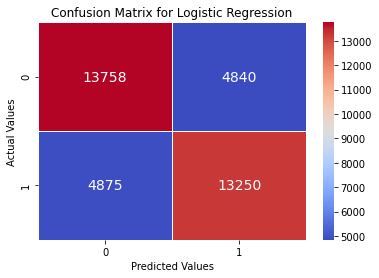

In [20]:
sns.heatmap(confusion_matrix(y_test, classifier_lr.predict(X_test)), annot= True, cmap= 'coolwarm', fmt=".0f",annot_kws = {"size": 14}, linewidths = 0.5)
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

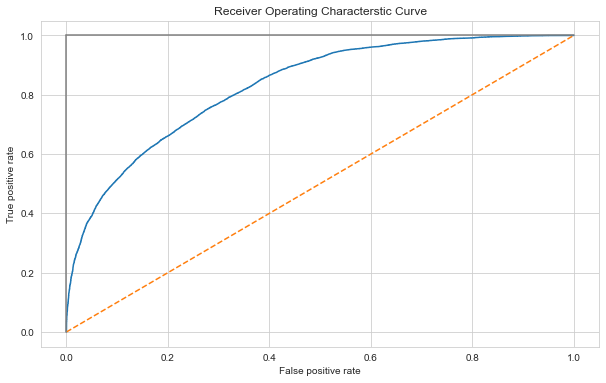

In [21]:
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
target_probailities_lr = classifier_lr.predict_proba(X_test)[:,1]
log_false_positive_rate,log_true_positive_rate,log_threshold = roc_curve(y_test,target_probailities_lr)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characterstic Curve')
plt.plot(log_false_positive_rate,log_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [22]:
area =[]
print("Area Under Curve:", roc_auc_score(y_test,target_probailities_lr))
area.append(roc_auc_score(y_test,target_probailities_lr))

Area Under Curve: 0.829840984013854


# KNearestNeighbors

In [23]:
from sklearn.neighbors import KNeighborsClassifier
classifier_kn = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2)
classifier_kn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [24]:
# from sklearn.model_selection import GridSearchCV
# parameters_kn = [{"n_neighbors": [10,20,50,60], 'weights': ['uniform', 'distance']}]
# grid_search_kn = GridSearchCV(estimator = classifier_kn, 
#                            param_grid = parameters_kn,
#                            scoring = 'accuracy', 
#                            cv = 10,
#                            n_jobs = -1)
# grid_search_kn = grid_search_kn.fit(X_train, y_train)
# best_accuracy_kn = grid_search_kn.best_score_
# best_parameters_kn = grid_search_kn.best_params_
# print(best_parameters_kn)

In [25]:
print("Test Set:")
print("Accuracy = {:.2f}".format(accuracy_score(y_test, classifier_kn.predict(X_test))), "Confusion Matrix: ", confusion_matrix(y_test, classifier_kn.predict(X_test)), sep = "\n")

Test Set:
Accuracy = 0.72
Confusion Matrix: 
[[14152  4446]
 [ 5912 12213]]


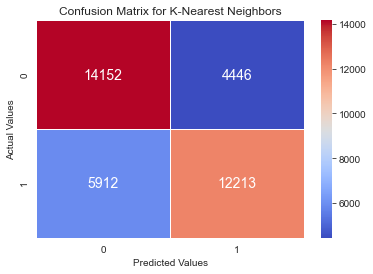

In [26]:
sns.heatmap(confusion_matrix(y_test, classifier_kn.predict(X_test)), annot= True, cmap= 'coolwarm', fmt=".0f",annot_kws = {"size": 14}, linewidths = 0.5)
plt.title("Confusion Matrix for K-Nearest Neighbors")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

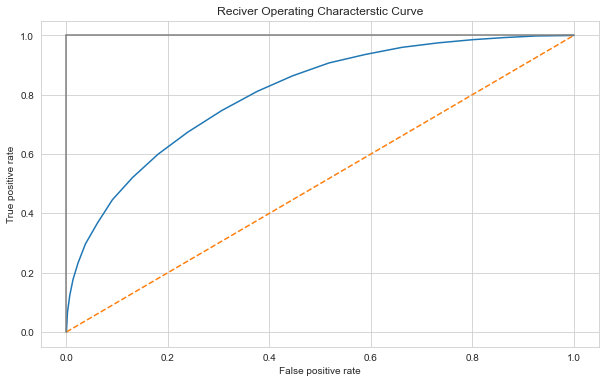

In [27]:
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
target_probailities_kn = classifier_kn.predict_proba(X_test)[:,1]
kn_false_positive_rate,kn_true_positive_rate,kn_threshold = roc_curve(y_test,
                                                             target_probailities_kn)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(kn_false_positive_rate,kn_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## Decision Tree Model

In [28]:
from sklearn.tree import DecisionTreeClassifier
classifier_dt =  DecisionTreeClassifier(random_state = 0)
classifier_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [29]:
print("Test Set:")
print("Accuracy = {:.2f}".format(accuracy_score(y_test, classifier_dt.predict(X_test))), "Confusion Matrix: ", confusion_matrix(y_test, classifier_dt.predict(X_test)), sep = "\n")

Test Set:
Accuracy = 0.81
Confusion Matrix: 
[[15174  3424]
 [ 3451 14674]]


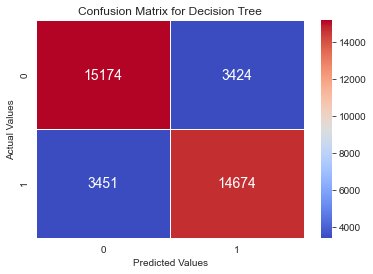

In [30]:
sns.heatmap(confusion_matrix(y_test, classifier_dt.predict(X_test)), annot= True, cmap= 'coolwarm', fmt=".0f",annot_kws = {"size": 14}, linewidths = 0.5)
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

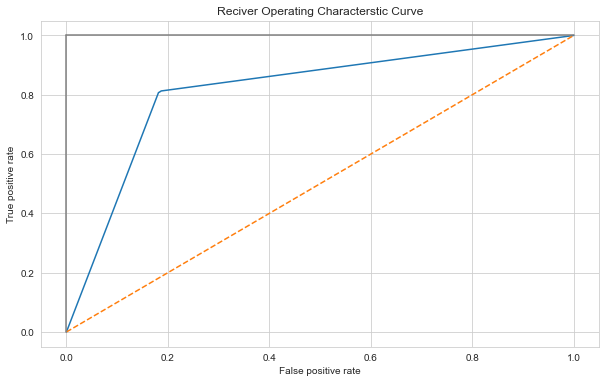

In [31]:
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
target_probailities_dt = classifier_dt.predict_proba(X_test)[:,1]
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = roc_curve(y_test,
                                                             target_probailities_dt)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(dt_false_positive_rate,dt_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [32]:
print("Area Under Curve:", roc_auc_score(y_test,target_probailities_dt))
area.append(roc_auc_score(y_test,target_probailities_dt))

Area Under Curve: 0.8146655161289127


## Training the Random Forest model

Now its time to train our model!

**Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.**

In [33]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators = 10, random_state = 0)
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [34]:

print("Test Set:")
print("Accuracy = {:.2f}".format(accuracy_score(y_test, classifier_rf.predict(X_test))), "Confusion Matrix: ", confusion_matrix(y_test, classifier_rf.predict(X_test)), sep = "\n")

Test Set:
Accuracy = 0.84
Confusion Matrix: 
[[16281  2317]
 [ 3507 14618]]


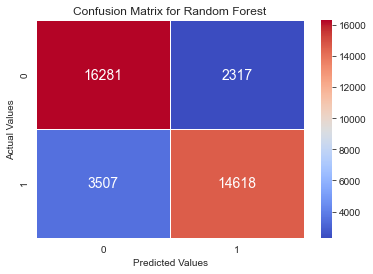

In [35]:
sns.heatmap(confusion_matrix(y_test, classifier_rf.predict(X_test)), annot= True, cmap= 'coolwarm', fmt=".0f",annot_kws = {"size": 14}, linewidths = 0.5)
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

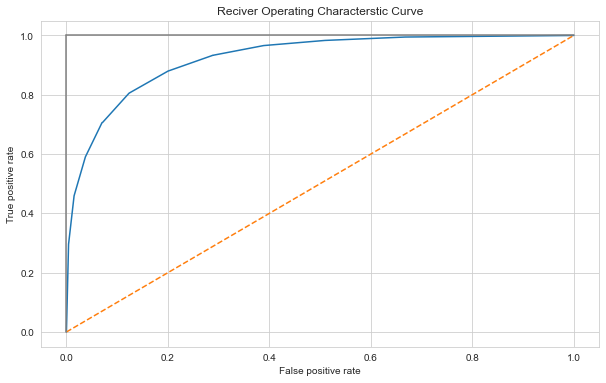

In [36]:
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
target_probailities_rf = classifier_rf.predict_proba(X_test)[:,1]
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,
                                                             target_probailities_rf)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(rf_false_positive_rate,rf_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [37]:
print("Area Under Curve:", roc_auc_score(y_test,target_probailities_rf))
area.append(roc_auc_score(y_test,target_probailities_rf))

Area Under Curve: 0.9234108213341441


# Great Job!